# Создание  модели `Модуль упругости при растяжении`

## Установка дополнительных библиотек

In [1]:
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install ipywidgets -q

## Импорт всех необходимых библиотек 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [5]:
#дополнительные библиотеки и настройки
import optuna
import pickle
import warnings
warnings.simplefilter("ignore")
!jupyter nbextension enable --py widgetsnbextension
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('dark')
%matplotlib inline

## Загрузка предобработанного датасета

In [6]:
df = pd.read_csv('../datasets/elasticity_model_vkr.csv', index_col=0)
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.696935,0.552471,0.367298,0.475618,0.555153,0.576459,0.287445,0.244377,0.525312,0.469397,0.866229,0.719823,0.604509
1,0.556320,0.678011,0.341620,0.289033,0.432249,0.446750,0.300944,0.244459,0.522610,0.570130,0.000000,0.492997,0.616700
2,0.535489,0.701749,0.294661,0.185315,0.429536,0.517709,0.294551,0.244461,0.511602,0.607502,0.000000,0.490102,0.626317
3,0.455555,0.240643,0.413489,0.470654,0.620018,0.640497,0.288643,0.244500,0.594939,0.683312,0.096054,0.424105,0.752467
4,0.687389,0.503117,0.371152,0.490116,0.578938,0.608599,0.285072,0.244503,0.532272,0.483065,0.899889,0.717927,0.620202


In [7]:
df.shape

(1590, 13)

In [8]:
df.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

## Обучение модели для прогноза модуля упругости при растяжении


##### Создадим датасет для тестирования модуля упругости при растяжении X При этом исключим переменную Модуль упругости при растяжении, ГПа, и присвоим отдельной переменной y.

In [9]:
X = df.drop(['Модуль упругости при растяжении, ГПа','Прочность при растяжении, МПа'], axis=1)
y = df[['Модуль упругости при растяжении, ГПа']]

In [ ]:
#Преобразуем в ndarray
X = np.asarray(X)
y = np.asarray(y)

#### Разделим на тренировочные и тестовые выборки

In [10]:
#Train_test_split для модуля упругости при растяжении
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1113, 11) (477, 11) (1113, 1) (477, 1)


In [12]:
#инициализируем словари для сохранения метрик
r2_scores = {}
mae_scores = {}
rmse_scores = {}
max_scores = {}

In [13]:
#установим количесво фолдов для кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Ridge regression

In [14]:
#гиперпараметры для поиска по сетке
params = {'alpha': [alpha for alpha in np.arange(0.0001,0.001,0.00005)],
           "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
          'tol': [tol for tol in np.arange(0.001, 0.01, 0.0005)]
          }

In [15]:
#поиск гиперпараметров с перекрестной проверкой
estimator = Ridge()
def grid_search(estimator,params):
    gs = GridSearchCV(estimator=estimator,param_grid=params,
                    scoring='r2', cv=cv, return_train_score=True,
                    n_jobs=-1,verbose=1)
    
    gs = gs.fit(X_train, y_train)
    return gs

grid = grid_search(estimator,params)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


In [16]:
grid.best_params_

{'alpha': 0.0009500000000000002, 'solver': 'lsqr', 'tol': 0.009000000000000001}

In [17]:
ridge = Ridge(**grid.best_params_)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

    
print("          Ridge regression  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          Ridge regression  

R2 score: 0.034274230941392037 
Mean Absolute Error: 0.06571239392248612
Root Mean Squared Error: 0.093033084325035
Max Error: 0.7646196632135522


In [18]:
#сохраним результаты проверки протестированных моделей
r2_scores["Ridge"] = r2
mae_scores["Ridge"] = mae
rmse_scores["Ridge"] = rmse
max_scores["Ridge"] = max

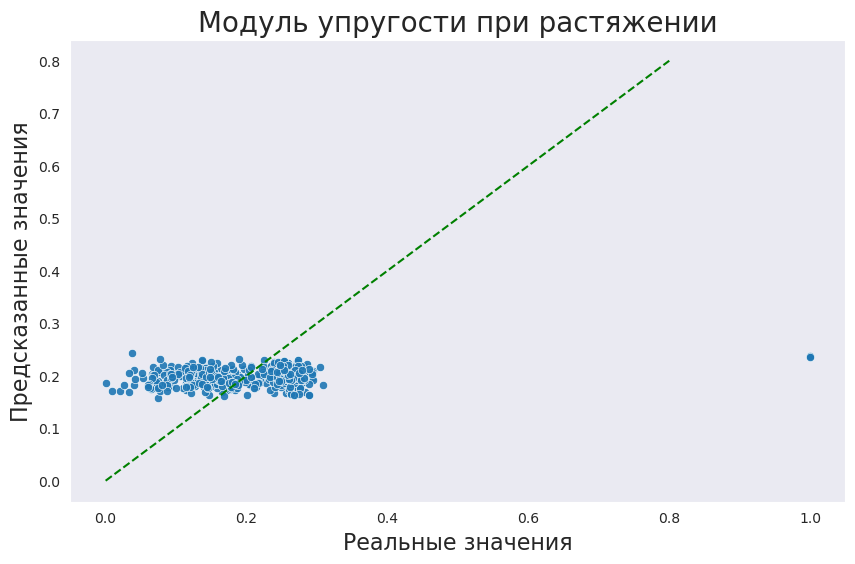

In [19]:
#сделаем визуализацию
def model_plot():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=np.ravel(y_test), y=np.ravel(y_pred), alpha=0.9)
    line_x, line_y = np.arange(0.0, 1.0, 0.2),np.arange(0.0, 1.0, 0.2)
    plt.plot(line_x, line_y, 'g--')
    plt.title("Модуль упругости при растяжении", fontsize=20)
    plt.xlabel('Реальные значения', fontsize=16)
    plt.ylabel('Предсказанные значения', fontsize=16)
    plt.show()

model_plot()

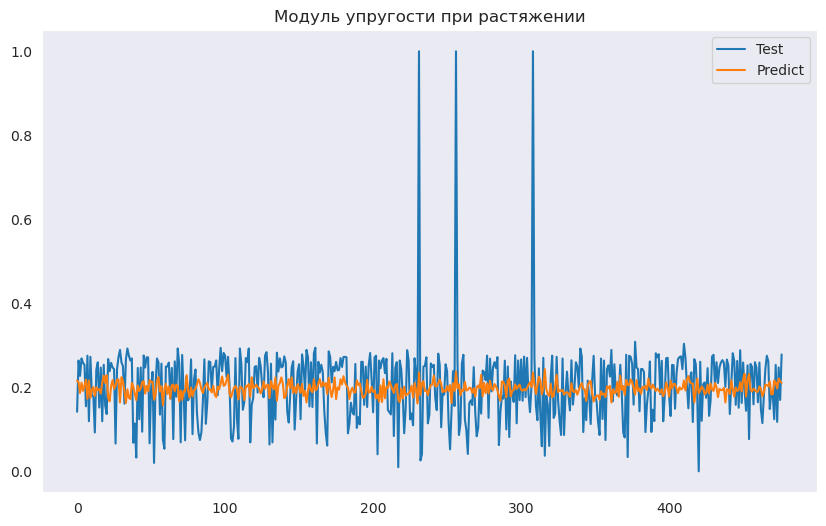

In [20]:
#Визуализация предсказанных значений целевой переменной
def pred_plot(y_test, y_pred):
  plt.figure(figsize=(10, 6))
  plt.title('Модуль упругости при растяжении')
  plt.plot(y_test, label='Test')
  plt.plot(y_pred, label='Predict')
  plt.legend(loc='best')
pred_plot(y_test, y_pred)

In [21]:
ridge = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
ridge.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.141800,0.263694,0.227134,0.268685,0.258370,0.253548,0.154657,0.275228,0.119302,0.272459,0.181068,0.178155,0.092394,0.241706,0.259604,0.151717,0.246969,0.119107,0.253570,0.156548
Предсказанные,0.216186,0.212378,0.186426,0.210898,0.191495,0.204065,0.218186,0.172448,0.216152,0.174917,0.194480,0.200226,0.179565,0.199865,0.193144,0.195564,0.184974,0.210901,0.227596,0.210381


## Support Vector Regression

In [ ]:
#поиск гиперпараметров с перекрестной проверкой
def objective_svm(trial):
    params = {
        "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
        "tol": trial.suggest_float("tol", 0.001, 0.01, step=0.001,log=False),
        "C": trial.suggest_categorical("C", [0.1, 1, 10, 100, 1000]),
        "gamma": trial.suggest_categorical("gamma", [1, 0.1, 0.01, 0.001, 0.0001])
        
    }
    score = cross_val_score(SVR(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_svm, n_trials=25, n_jobs=-1)

In [23]:
study.best_params

{'kernel': 'rbf', 'tol': 0.002, 'C': 0.1, 'gamma': 1}

In [24]:
svr = SVR(**study.best_params)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          Support Vector Regression  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          Support Vector Regression  

R2 score: 0.02519555162913545 
Mean Absolute Error: 0.06716136822136248
Root Mean Squared Error: 0.09346935816306394
Max Error: 0.768466853980202


In [25]:
#сохраним результаты проверки протестированных моделей
r2_scores["SVR"] = r2
mae_scores["SVR"] = mae
rmse_scores["SVR"] = rmse
max_scores["SVR"] = max

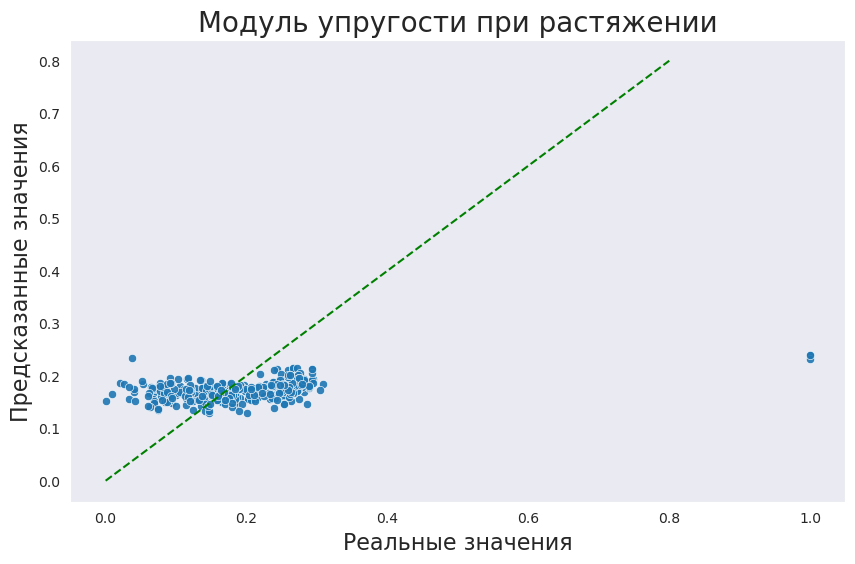

In [26]:
#сделаем визуализацию
model_plot()

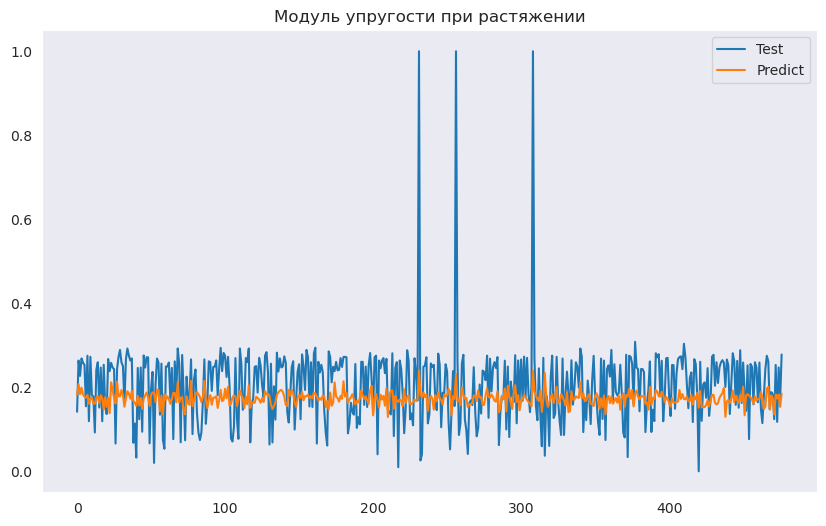

In [27]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [28]:
svr = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
svr.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.141800,0.263694,0.227134,0.268685,0.258370,0.253548,0.154657,0.275228,0.119302,0.272459,0.181068,0.178155,0.092394,0.241706,0.259604,0.151717,0.246969,0.119107,0.253570,0.156548
Предсказанные,0.182471,0.207672,0.183561,0.199028,0.183298,0.177577,0.175193,0.182066,0.160612,0.174120,0.176162,0.161054,0.160997,0.175510,0.178605,0.161935,0.180913,0.174270,0.146779,0.176480


## KNeighborsRegressor

In [29]:
#гиперпараметры для поиска по сетке
params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          }

In [30]:
#поиск гиперпараметров с перекрестной проверкой
estimator = KNeighborsRegressor()
grid = grid_search(estimator,params)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [31]:
grid.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 15,
 'weights': 'distance'}

In [32]:
neighbors = KNeighborsRegressor(**grid.best_params_)
                             
neighbors.fit(X_train, y_train)
y_pred = neighbors.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          KNeighborsRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          KNeighborsRegressor  

R2 score: 0.5954157288445387 
Mean Absolute Error: 0.03727129848376858
Root Mean Squared Error: 0.0602164303399958
Max Error: 0.3792626155352497


In [33]:
#сохраним результаты проверки протестированных моделей
r2_scores["K-neighbors"] = r2
mae_scores["K-neighbors"] = mae
rmse_scores["K-neighbors"] = rmse
max_scores["K-neighbors"] = max

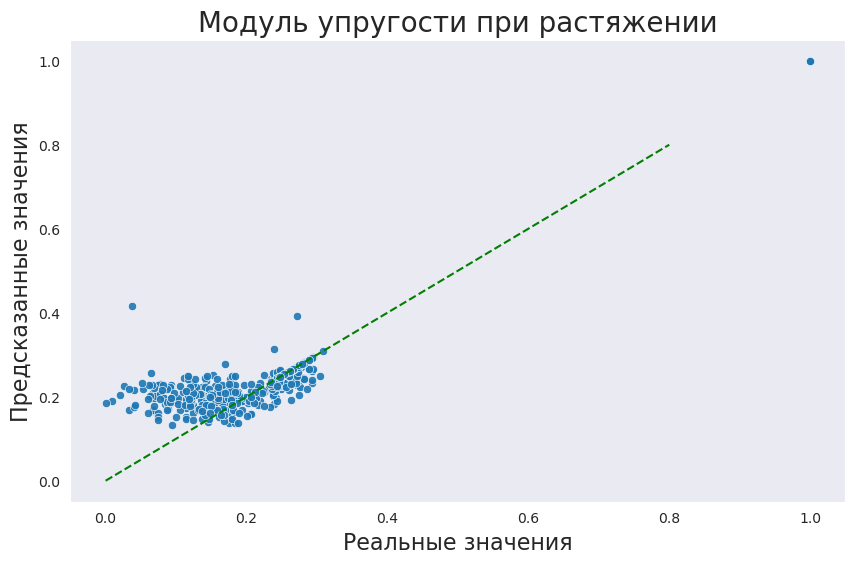

In [34]:
#сделаем визуализацию
model_plot()

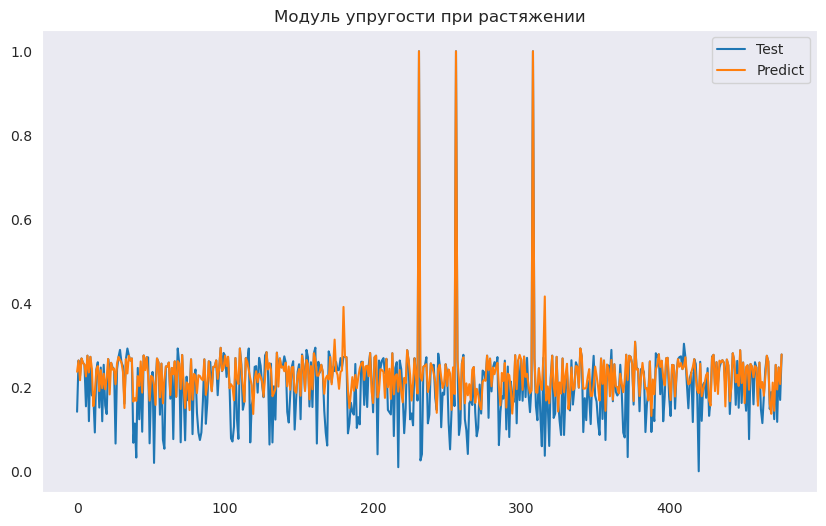

In [35]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [36]:
k_neighbors = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
k_neighbors.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.141800,0.263694,0.227134,0.268685,0.25837,0.253548,0.154657,0.275228,0.119302,0.272459,0.181068,0.178155,0.092394,0.241706,0.259604,0.151717,0.246969,0.119107,0.253570,0.156548
Предсказанные,0.236972,0.263694,0.216899,0.268685,0.25837,0.253548,0.225883,0.275228,0.235445,0.272459,0.244199,0.154969,0.187207,0.240952,0.250478,0.191054,0.240729,0.197893,0.232187,0.195323


## RandomForestRegressor

In [ ]:
#поиск гиперпараметров с перекрестной проверкой
def objective_randomforest(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=1, log=False),
        "max_depth": trial.suggest_int("max_depth", 10, 100, 10),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
        
    }
    score = cross_val_score(RandomForestRegressor(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_randomforest, n_trials=25, n_jobs=-1)

In [38]:
study.best_params

{'n_estimators': 100,
 'min_samples_split': 4,
 'max_depth': 40,
 'max_features': 'log2',
 'bootstrap': False}

In [39]:
forest = RandomForestRegressor(**study.best_params)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          RandomForestRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          RandomForestRegressor  

R2 score: 0.7302395626370211 
Mean Absolute Error: 0.031216834640279974
Root Mean Squared Error: 0.0491699354143422
Max Error: 0.32663234505088956


In [40]:
#сохраним результаты проверки протестированных моделей
r2_scores["RandomForest"] = r2
mae_scores["RandomForest"] = mae
rmse_scores["RandomForest"] = rmse
max_scores["RandomForest"] = max

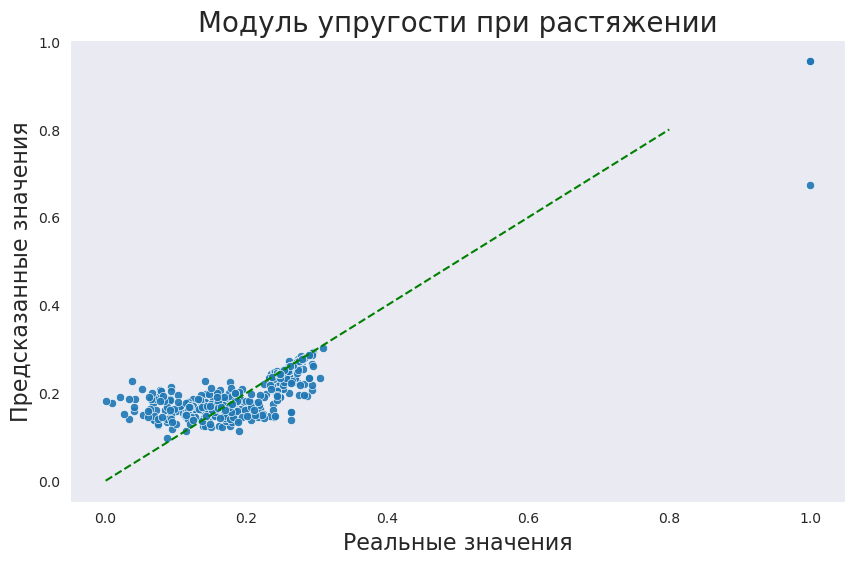

In [41]:
#сделаем визуализацию
model_plot()

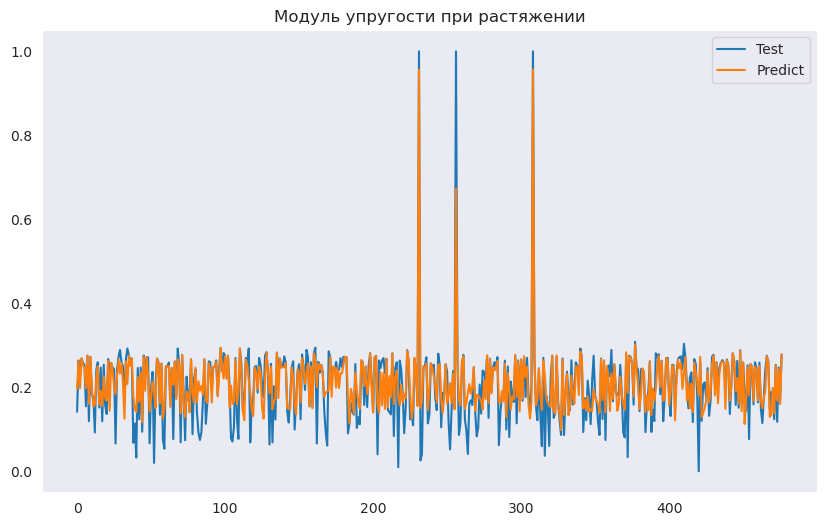

In [42]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [43]:
random_forest = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
random_forest.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.14180,0.263694,0.227134,0.268685,0.258370,0.253548,0.154657,0.275228,0.119302,0.272459,0.181068,0.178155,0.092394,0.241706,0.259604,0.151717,0.246969,0.119107,0.253570,0.156548
Предсказанные,0.19704,0.264132,0.197978,0.268259,0.253052,0.246084,0.198017,0.275186,0.160430,0.272460,0.195715,0.154618,0.159415,0.220469,0.249462,0.159310,0.191410,0.154885,0.225702,0.174336


## ExtraTreesRegressor

In [ ]:
#поиск гиперпараметров с перекрестной проверкой
def objective_extratree(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=1, log=False),
        "max_depth": trial.suggest_int("max_depth", 10, 100, 10),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
        
    }
    score = cross_val_score(ExtraTreesRegressor(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_extratree, n_trials=25, n_jobs=-1)

In [45]:
study.best_params


{'n_estimators': 250,
 'min_samples_split': 4,
 'max_depth': 100,
 'max_features': 'log2',
 'bootstrap': False}

In [46]:
extra = ExtraTreesRegressor(**study.best_params, n_jobs=-1)
extra.fit(X_train, y_train)

y_pred = extra.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          ExtraTreesRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          ExtraTreesRegressor  

R2 score: 0.7256803647366684 
Mean Absolute Error: 0.033307577299111595
Root Mean Squared Error: 0.049583702897398635
Max Error: 0.29059321701490015


In [47]:
#сохраним результаты проверки протестированных моделей
r2_scores["ExtraTreesRegressor"] = r2
mae_scores["ExtraTreesRegressor"] = mae
rmse_scores["ExtraTreesRegressor"] = rmse
max_scores["ExtraTreesRegressor"] = max

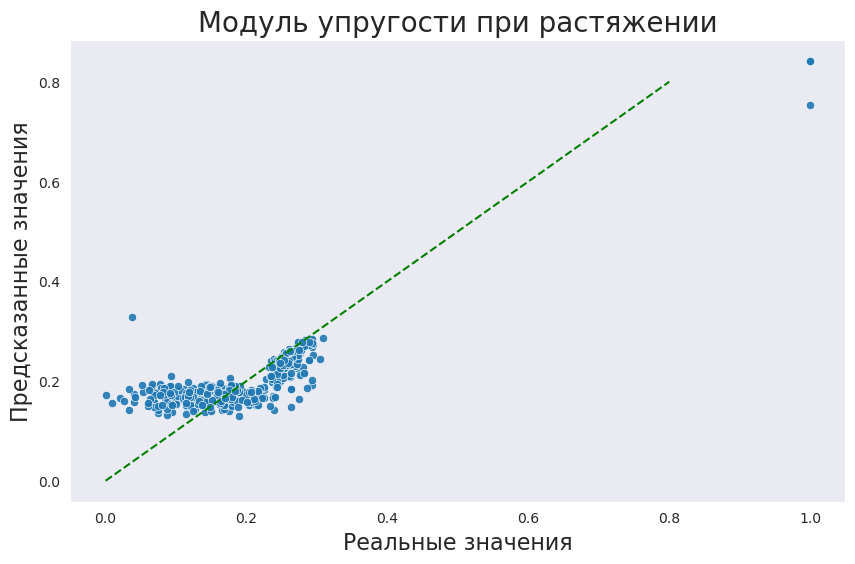

In [48]:
#сделаем визуализацию
model_plot()

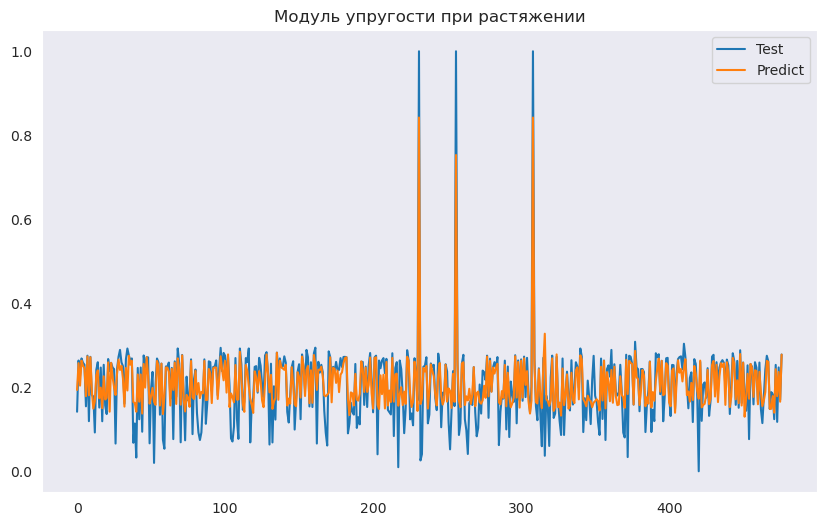

In [49]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [50]:
extra_tree = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
extra_tree.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.141800,0.263694,0.227134,0.268685,0.258370,0.253548,0.154657,0.275228,0.119302,0.272459,0.181068,0.178155,0.092394,0.241706,0.259604,0.151717,0.246969,0.119107,0.253570,0.156548
Предсказанные,0.193576,0.257443,0.203933,0.263507,0.251595,0.245713,0.178852,0.273441,0.180885,0.271551,0.189391,0.149281,0.166841,0.228733,0.240388,0.173892,0.199183,0.150325,0.226127,0.170859


## XGBRegressor

In [51]:
#поиск гиперпараметров с перекрестной проверкой
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, 50),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.05,0.10,0.15,0.20,0.25,0.30]),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1, log=False),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1, log=False),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5, step=0.1, log=False),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1, log=False),
        "random_state": trial.suggest_int("random_state", 1, 10, step=1, log=False),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 3, step=1, log=False),
    }
    score = cross_val_score(XGBRegressor(**params),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=25, n_jobs=-1)

In [52]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'gamma': 0.0,
 'colsample_bytree': 0.8,
 'random_state': 7,
 'scale_pos_weight': 2}

In [53]:
xgb = XGBRegressor(**study.best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred , force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

print("          XGBRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          XGBRegressor  

R2 score: 0.7009050123587206 
Mean Absolute Error: 0.035041302664535534
Root Mean Squared Error: 0.05177440025455934
Max Error: 0.21948637068271637


In [54]:
#сохраним результаты проверки протестированных моделей
r2_scores["XGBoost"] = r2
mae_scores["XGBoost"] = mae
rmse_scores["XGBoost"] = rmse
max_scores["XGBoost"] = max

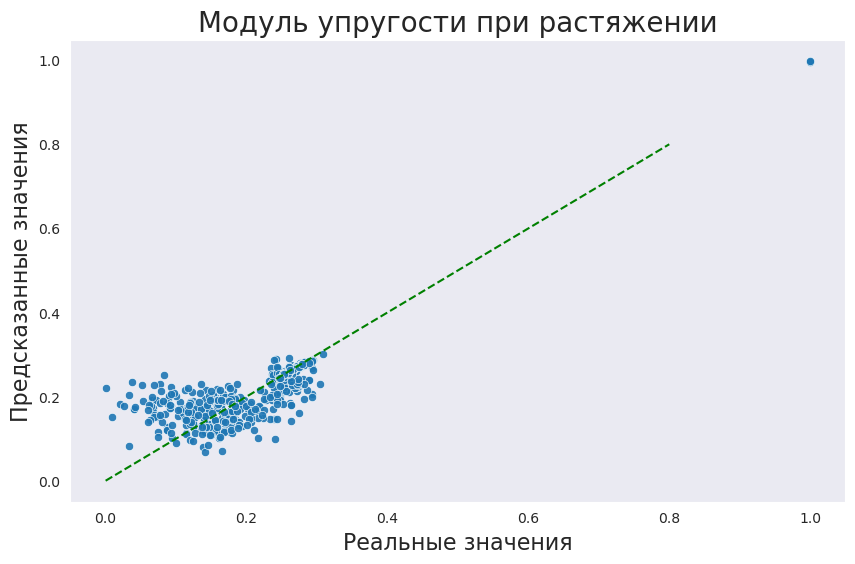

In [55]:
#сделаем визуализацию
model_plot()

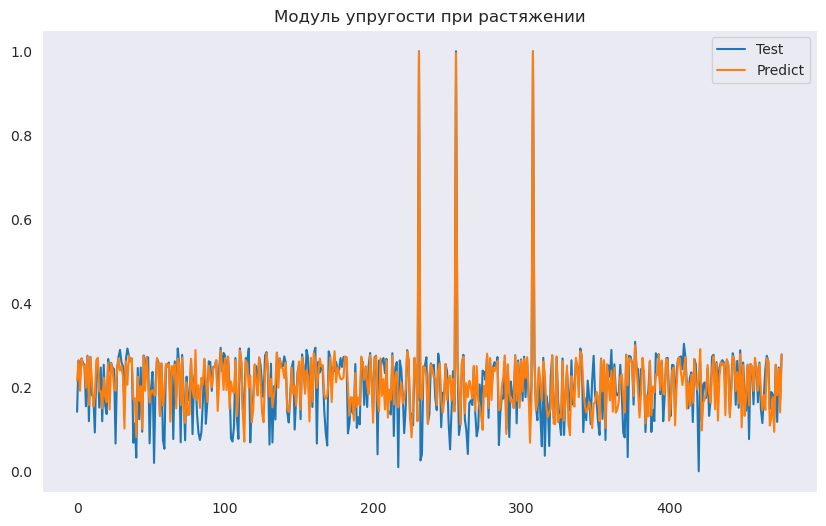

In [56]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [57]:
xgboost = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
xgboost.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Актуальные,0.141800,0.263694,0.227134,0.268685,0.258370,0.253548,0.154657,0.275228,0.119302,0.272459,0.181068,0.178155,0.092394,0.241706,0.259604,0.151717,0.246969,0.119107,0.253570,0.156548
Предсказанные,0.216046,0.264160,0.191652,0.267899,0.253693,0.250079,0.198691,0.273780,0.157527,0.271949,0.216289,0.153846,0.178674,0.264586,0.270068,0.190021,0.191602,0.149557,0.223169,0.175419


## CatBoostRegressor

In [58]:
#поиск гиперпараметров с перекрестной проверкой
def objective_catboost(trial):
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.001,0.01, 0.02, 0.03, 0.1, 1.0]),
        "l2_leaf_reg": trial.suggest_discrete_uniform("l2_leaf_reg", 1, 9, 2),
        "depth": trial.suggest_categorical("depth", [2,4,6,8,10])
        
    }
    score = cross_val_score(CatBoostRegressor(**params,verbose=0,iterations=100),
                            X_train, y_train, cv=cv, scoring='r2', n_jobs=-1).mean()
    return score
study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=25, n_jobs=-1)

In [59]:
study.best_params

{'learning_rate': 0.1, 'l2_leaf_reg': 7.0, 'depth': 10}

In [60]:
cat = CatBoostRegressor(**study.best_params, thread_count=-1)
cat.fit(X_train, y_train, verbose=0, early_stopping_rounds = 30,plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
y_pred = cat.predict(X_test)

r2 = r2_score(y_test, y_pred, force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)


print("          CatBoostRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          CatBoostRegressor  

R2 score: 0.7488759355158165 
Mean Absolute Error: 0.029935201095910698
Root Mean Squared Error: 0.04744109180014984
Max Error: 0.2547596136223475


In [63]:
#сохраним результаты проверки протестированных моделей
r2_scores["CatBoost"] = r2
mae_scores["CatBoost"] = mae
rmse_scores["CatBoost"] = rmse
max_scores["CatBoost"] = max

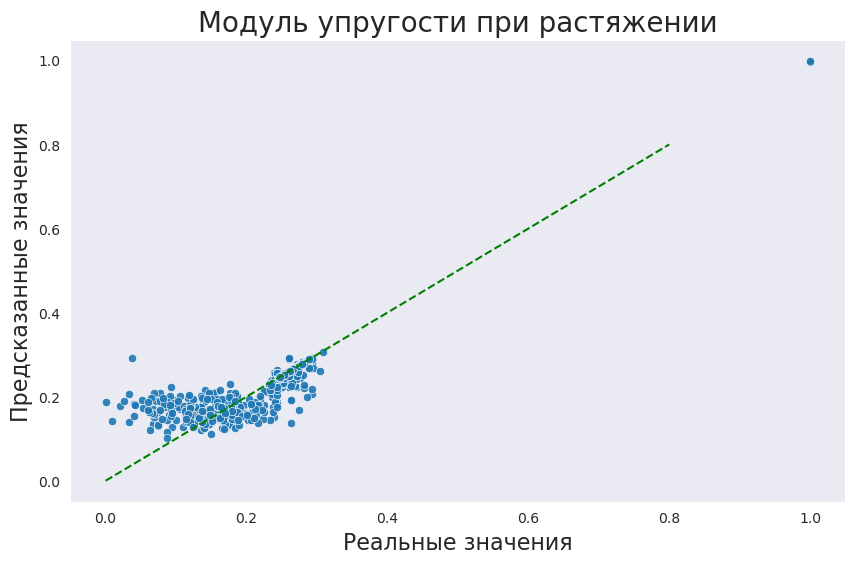

In [64]:
#сделаем визуализацию
model_plot()

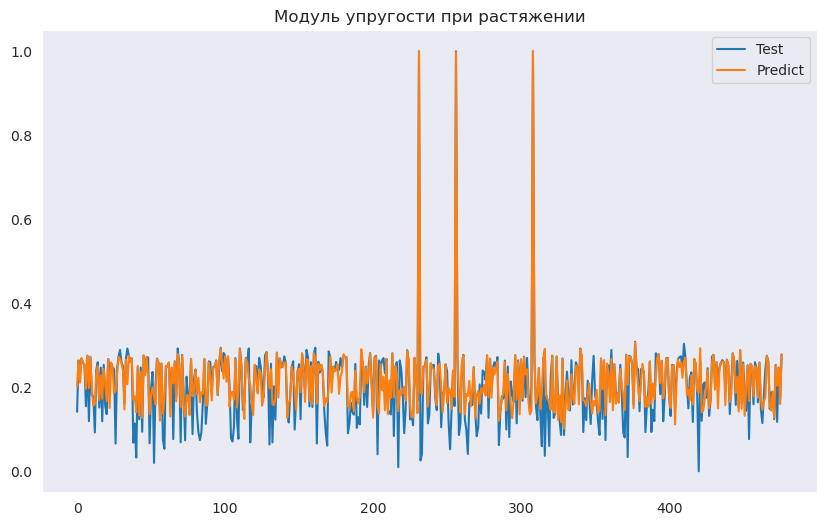

In [65]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [66]:
catboost = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
catboost.tail(20).T

,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476
Актуальные,0.159337,0.259604,0.246754,0.164315,0.258894,0.148068,0.114704,0.179477,0.242769,0.275058,0.261513,0.148272,0.188488,0.183158,0.124039,0.253291,0.117656,0.247233,0.169857,0.278027
Предсказанные,0.178379,0.250221,0.246368,0.175362,0.258735,0.170898,0.146220,0.166506,0.175942,0.273649,0.261619,0.155295,0.144501,0.190398,0.127674,0.252287,0.203940,0.246562,0.160192,0.277970


## VotingRegressor

In [ ]:
vr = VotingRegressor([('r', forest), ('c', cat)])
vr.fit(X_train, y_train)
y_pred = vr.predict(X_test)

r2 = r2_score(y_test, y_pred , force_finite=False)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
max = max_error(y_test, y_pred)

In [84]:
print("          VotingRegressor  ")
print()
print(f"R2 score: {r2} ")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Max Error: {max}")

          VotingRegressor  

R2 score: 0.7530022653871145 
Mean Absolute Error: 0.02998597893863524
Root Mean Squared Error: 0.04704971470401629
Max Error: 0.22266605655948285


In [85]:
#сохраним результаты проверки протестированных моделей
r2_scores["VotingRegressor"] = r2
mae_scores["VotingRegressor"] = mae
rmse_scores["VotingRegressor"] = rmse
max_scores["VotingRegressor"] = max

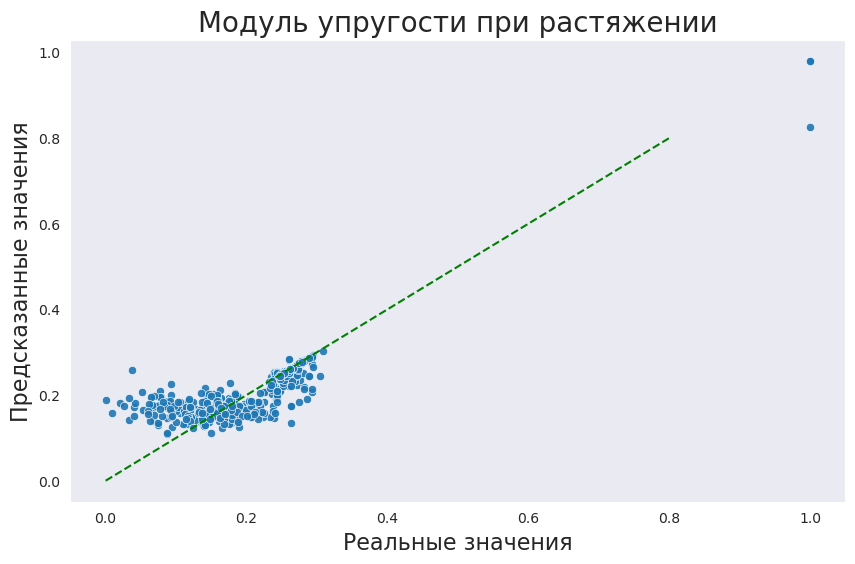

In [86]:
#сделаем визуализацию
model_plot()

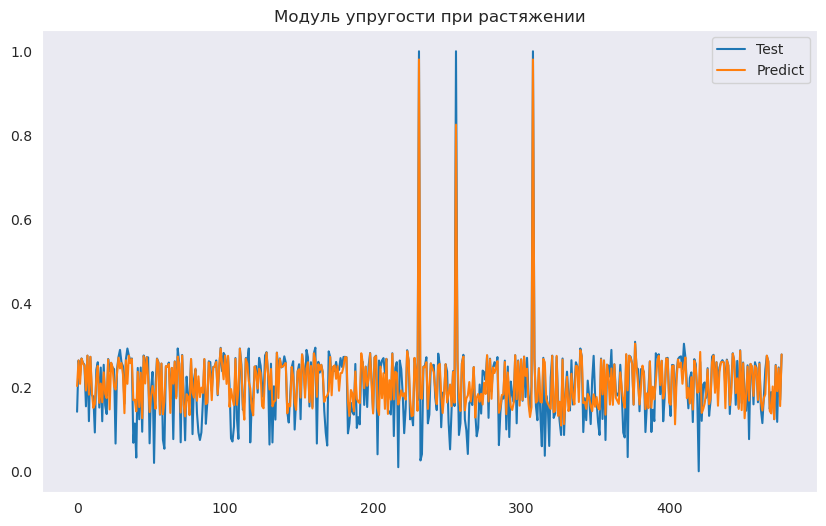

In [87]:
#Визуализация предсказанных значений целевой переменной
pred_plot(y_test, y_pred)

In [88]:
voting = pd.DataFrame({'Актуальные': np.ravel(y_test), 'Предсказанные': np.ravel(y_pred)})
voting.tail(20).T

,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476
Актуальные,0.159337,0.259604,0.246754,0.164315,0.258894,0.148068,0.114704,0.179477,0.242769,0.275058,0.261513,0.148272,0.188488,0.183158,0.124039,0.253291,0.117656,0.247233,0.169857,0.278027
Предсказанные,0.179485,0.250773,0.244591,0.169766,0.255534,0.167279,0.144705,0.174128,0.183683,0.275264,0.261667,0.143624,0.137741,0.201960,0.123995,0.251607,0.190656,0.245002,0.155251,0.278023


In [89]:
scores= [r2_scores, mae_scores, rmse_scores, max_scores]

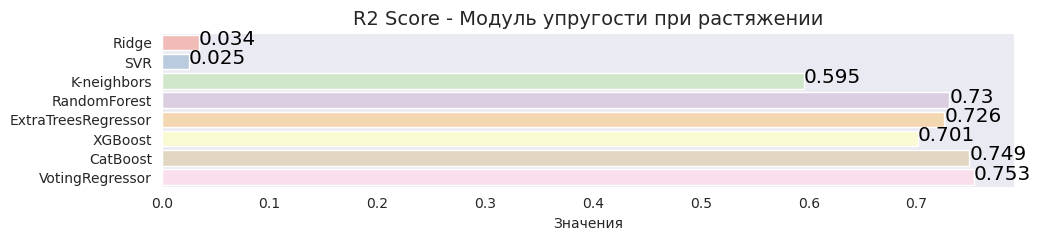

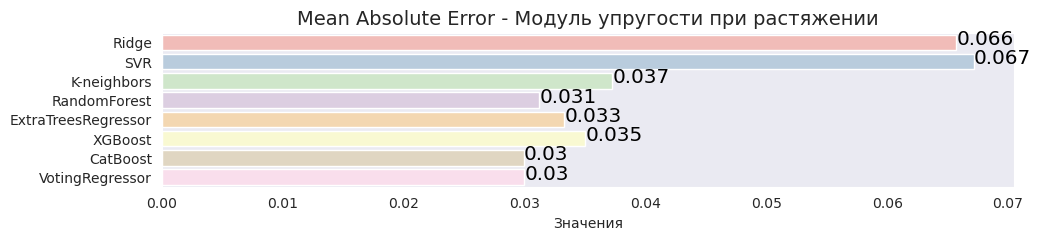

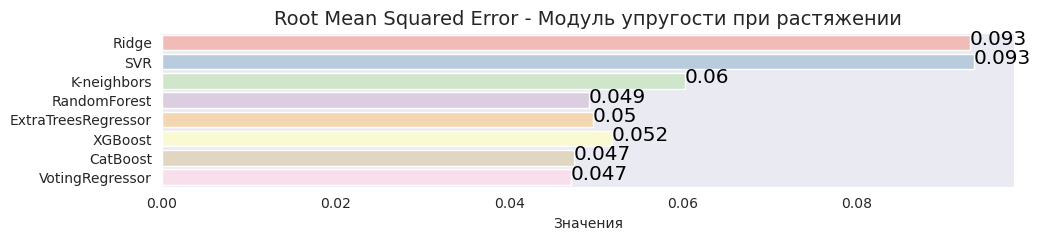

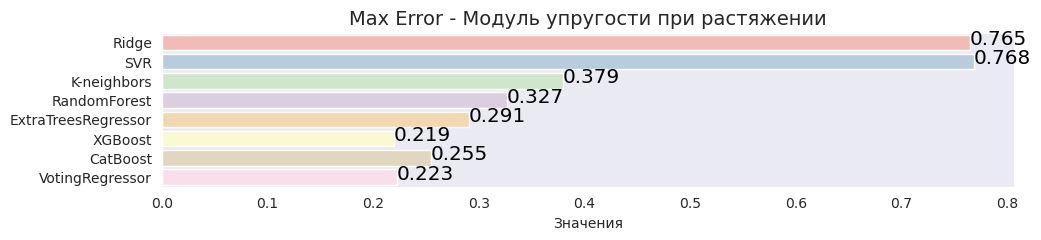

In [90]:
#визуализируем  метрики
titles = ['R2 Score - Модуль упругости при растяжении',
          'Mean Absolute Error - Модуль упругости при растяжении',
          'Root Mean Squared Error - Модуль упругости при растяжении',
          'Max Error - Модуль упругости при растяжении']


for i in range(len(scores)):
    plt.figure(figsize=(11, 2))
    render = sns.barplot(x=list(scores[i].values()), y=list(
        scores[i].keys()), palette="Pastel1")
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Значения", fontsize=10)
    # plt.ylabel("Модель", fontsize=14)

   
    for j in render.patches:
        if not np.math.isnan(j.get_width()):
            x = j.get_width() - render.patches[0].get_width()*0
            y = j.get_y() + j.get_height() - 0.3
            value = round(j.get_width(), 3)
            render.text(x, y, value, ha="left", color='black', size='x-large')
    plt.show()

## Сохранение лучшей модели

In [ ]:
cat.save_model('../web_app/models/elasticity.cbm',format='cbm')

In [91]:
with open('../web_app/models/elasticity.pkl', 'wb') as file:
    pickle.dump(vr, file)